# Do Users from Certain Occupations Rate Genres Differently?
## Jacob Cuomo

### Data import, Merge, and Cleanse

In [2]:
# Import appropriate libraries
import pandas as pd # loading in data
import numpy as np
import matplotlib.pyplot as plt # creating visualizations
import seaborn as sns # also for creating visualizations

# for multiple regression model
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
# Import each individual dataset
users = pd.read_csv('users.dat', sep='::', names=["user_id","gender","age","occupation","zip_code"], engine='python')

ratings = pd.read_csv('ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'rating_timestamp'], engine='python')
ratings["rating_timestamp"] = pd.to_datetime(ratings["rating_timestamp"], unit='s') # Convert time stamp to datetime

movies = pd.read_csv('movies.dat', sep='::', header=None, names=['movie_id', 'movie_title', 'genres'], engine='python')

### CITATION: https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html

In [4]:
# Quickly look over variables in the user file
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   age         6040 non-null   int64 
 3   occupation  6040 non-null   int64 
 4   zip_code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [5]:
# Quickly look over variables in the ratings file
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1000209 non-null  int64         
 1   movie_id          1000209 non-null  int64         
 2   rating            1000209 non-null  int64         
 3   rating_timestamp  1000209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 30.5 MB


In [6]:
# Quickly look over variables in the movie file
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   movie_id     3883 non-null   int64 
 1   movie_title  3883 non-null   object
 2   genres       3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


In [7]:
# Merge the three datasets together
movieData = pd.merge(left=ratings, right=users, how='left', left_on='user_id', right_on='user_id')

### CITATION: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html

In [8]:
# Ensure the initial merge has added variables to the dataset
movieData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1000209 non-null  int64         
 1   movie_id          1000209 non-null  int64         
 2   rating            1000209 non-null  int64         
 3   rating_timestamp  1000209 non-null  datetime64[ns]
 4   gender            1000209 non-null  object        
 5   age               1000209 non-null  int64         
 6   occupation        1000209 non-null  int64         
 7   zip_code          1000209 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 68.7+ MB


In [9]:
# Merge the three datasets together
movieData = pd.merge(left=movieData, right=movies, how='left', left_on='movie_id', right_on='movie_id')

### CITATION: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html

In [10]:
# Ensure that the merge has fully incorporated variables into one dataset
movieData.head()

,user_id,movie_id,rating,rating_timestamp,gender,age,occupation,zip_code,movie_title,genres
0,1,1193,5,2000-12-31 22:12:40,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,2000-12-31 22:35:09,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,2000-12-31 22:32:48,F,1,10,48067,My Fair Lady (1964),Musical|Romance
3,1,3408,4,2000-12-31 22:04:35,F,1,10,48067,Erin Brockovich (2000),Drama
4,1,2355,5,2001-01-06 23:38:11,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [11]:
# Create a copy of the dataset to modify by splitting the genres across columns (for later models)
splitMovies = movieData.copy(deep=True)

In [12]:
# Split genres across columns to facilitate later analyses involving genre
splitMovies = pd.concat([movieData,movieData.genres.str.get_dummies(sep='|')],1)

### CITATION: https://intellipaat.com/community/8334/split-column-into-unknown-number-of-columns-by-delimiter-pandas

In [13]:
# Ensure that the dummy variables have allowed us to split the 18 genres across columns
splitMovies.head()

,user_id,movie_id,rating,rating_timestamp,gender,age,occupation,zip_code,movie_title,genres,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1193,5,2000-12-31 22:12:40,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
1,1,661,3,2000-12-31 22:35:09,F,1,10,48067,James and the Giant Peach (1996),Animation|Children's|Musical,...,0,0,0,1,0,0,0,0,0,0
2,1,914,3,2000-12-31 22:32:48,F,1,10,48067,My Fair Lady (1964),Musical|Romance,...,0,0,0,1,0,1,0,0,0,0
3,1,3408,4,2000-12-31 22:04:35,F,1,10,48067,Erin Brockovich (2000),Drama,...,0,0,0,0,0,0,0,0,0,0
4,1,2355,5,2001-01-06 23:38:11,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Create a copy of the dataset to modify by creating dummy variables for genre (for multiple regression)
dumMovies = movieData.copy(deep=True)

In [14]:
# Create dummy variables for genres/genre combinations
dummies = pd.get_dummies(dumMovies['genres'], drop_first = False)

# Drop the column for which we created the dummy variable
dumMovies = dumMovies.drop(['genres'], axis = 1)

# Merge the newly created dummy variables with the X set of predictors
dumMovies = pd.concat([dumMovies, dummies[['Animation|Comedy|Thriller', 'Sci-Fi|War', 'Animation',
                                           'Film-Noir|Mystery', 'Adventure|War']]], axis = 1) # highest rated genre combos

### CITATION: Prior data dive with Adam Loren Tschida, who derived this from Data 1500 and Predictive Modeling
### CITATION: https://pandas.pydata.org/docs/reference/api/pandas.concat.html

In [15]:
# Ensure that variables for the highest rated genre combinations (five) have been properly created
dumMovies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 14 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   user_id                    1000209 non-null  int64         
 1   movie_id                   1000209 non-null  int64         
 2   rating                     1000209 non-null  int64         
 3   rating_timestamp           1000209 non-null  datetime64[ns]
 4   gender                     1000209 non-null  object        
 5   age                        1000209 non-null  int64         
 6   occupation                 1000209 non-null  int64         
 7   zip_code                   1000209 non-null  object        
 8   movie_title                1000209 non-null  object        
 9   Animation|Comedy|Thriller  1000209 non-null  uint8         
 10  Sci-Fi|War                 1000209 non-null  uint8         
 11  Animation                  1000209 no

### Preliminary Graphs

##### User Visualizations

In [16]:
# Create variables for ticks and occupations used in the graph below on users in each occupation
occTicks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
occupations = ['Other', 'Academic', 'Artist', 'Clerical', 'College', 'Customer Service', 'Health Care', 'Executive',
               'Farmer', 'Homemaker', 'K-12 Student', 'Lawyer', 'Programmer', 'Retired', 'Sales', 'Scientist',
               'Self-Employed', 'Technician', 'Tradesman', 'Unemployed', 'Writer']

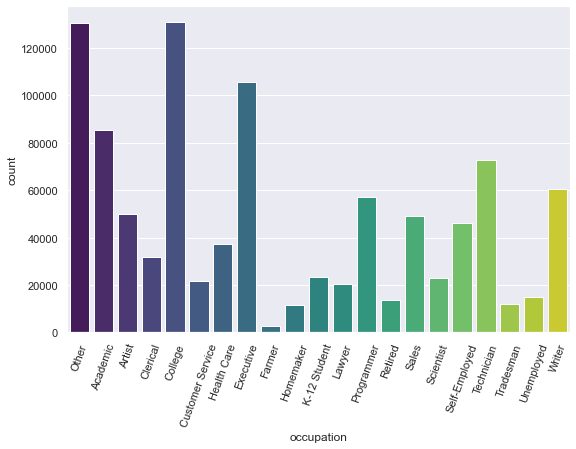

In [17]:
# Create a visualization for the number in each occupation
sns.set_theme(style="whitegrid") # from Data Science 1500
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x='occupation', data=movieData, capsize=.1, palette="viridis")

plt.xticks(occTicks, labels=occupations, rotation = 70) # set more descriptive, rotated labels

plt.show()

### CITATION: https://seaborn.pydata.org/generated/seaborn.countplot.html
### COLOR CITATION: https://medium.com/@morganjonesartist/color-guide-to-seaborn-palettes-da849406d44f
### LABEL CITATION: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html
### WHITEGRID CITATION: Dr. Scott Siepel, Data 1500

In [18]:
# Analyze the number of observations in each column to determine whether 4(college/grad student) or 0(other/not specified)
# has the most users.
movieData['occupation'].value_counts('')

# College/grad student has the most observations.

4     131032
0     130499
7     105425
1      85351
17     72816
20     60397
12     57214
2      50068
14     49109
16     46021
6      37205
3      31623
10     23290
15     22951
5      21850
11     20563
19     14904
13     13754
18     12086
9      11345
8       2706
Name: occupation, dtype: int64

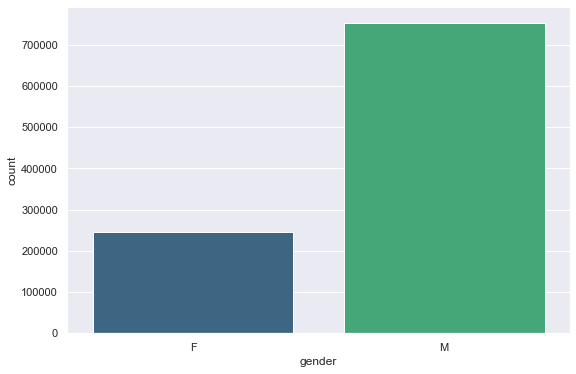

In [19]:
# Create a visualization for the number in each gender category
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x='gender', data=movieData, palette="viridis")

plt.show()

### CITATION: https://seaborn.pydata.org/generated/seaborn.countplot.html

In [20]:
# Note exactly how many users listed each gender
movieData['gender'].value_counts('')

M    753769
F    246440
Name: gender, dtype: int64

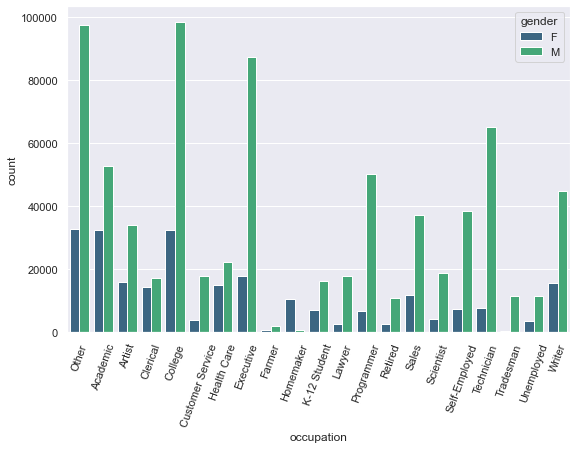

In [22]:
# Create a visualization for the number of users in each occupation and whether they are male or female
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x='occupation', hue='gender', data=movieData, palette="viridis")

plt.xticks(occTicks, labels=occupations, rotation = 70) # rotate the labels

plt.show()

### CITATION: https://seaborn.pydata.org/generated/seaborn.countplot.html
### LABEL CITATION: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xticks.html

In [23]:
# Create labels for the age category visualization below
ageTicks = [0, 1, 2, 3, 4, 5, 6]
ageCat = ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']

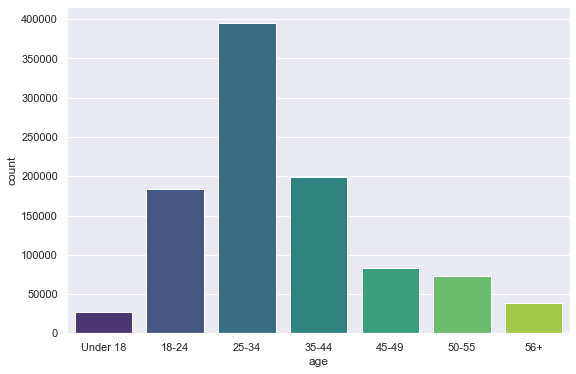

In [24]:
# Create age category visualization
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x='age', data=movieData, palette="viridis")

plt.xticks(ticks=ageTicks, labels=ageCat) # set more descriptive age category labels

plt.show()

### CITATION: https://seaborn.pydata.org/generated/seaborn.countplot.html

##### Movie Visualizations

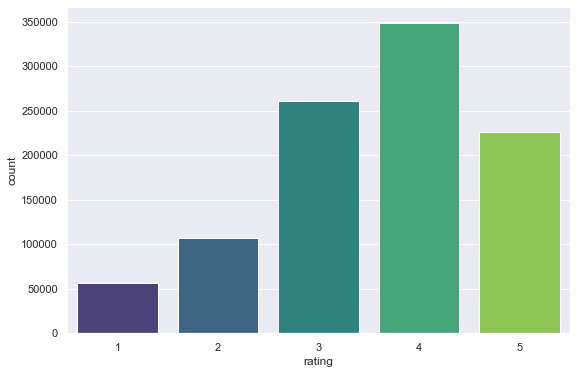

In [25]:
# Create a visualization for movie ratings
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})
sns.countplot(x='rating', data=movieData, capsize=.1, palette="viridis")

plt.show()

In [26]:
# Calculate the mean movie rating for the sample to use as a reference
meanRating = movieData['rating'].mean()
print(meanRating)

3.581564453029317


### Splitting by Genre/Occupation to Answer our Main Question

##### Genre/Occupation Visualizations

In [27]:
# use original dataset and create a function to later create a visualization for the number of movies in each genre
def genre_split():
    genres = []
    
    for x in movieData['genres']:
        if "|" in x:
            split_genres = x.split("|")
            for genre in split_genres:
                genres.append(genre)
        else:
            genres.append(x)
            
    return genres

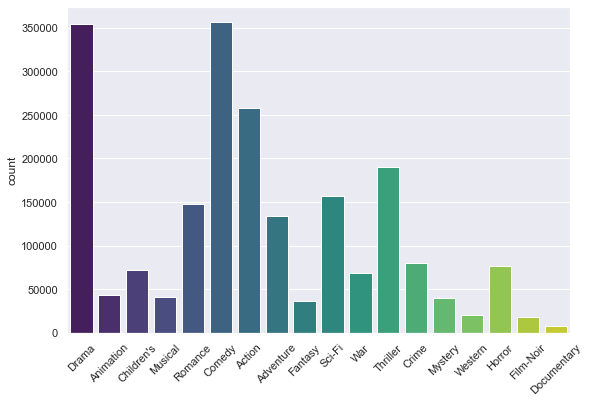

In [44]:
# Create a visualization for the number of movies in each genre
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})

sns.countplot(x=genre_split(), data=movieData, palette="viridis") # use the function to create the graph
plt.xticks(rotation=45) # rotate the movie genre names

plt.show()

### CITATION: https://stackoverflow.com/questions/26540035/rotate-label-text-in-seaborn-factorplot

In [2]:
df_corrBase = splitMovies.corr().round(3)
df_corrBase = pd.DataFrame(corrBase)
df_corrBase
df_corrBase.drop(labels=["user_id", "movie_id", "occupation", "Action", "Animation", "Children's", "Comedy", 
                         #"Crime", "Documentary", "Drama", "Adventure", "Fantasy", "Film-Noir", 
                         #"Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War",
                         #"Western"], axis=1, inplace=True)
df_corrBase.drop(labels=["user_id", "movie_id", "occupation"], axis=0, inplace=True)
df_corrBase

SyntaxError: invalid syntax (<ipython-input-2-fd55d5323480>, line 9)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '2578'),
  Text(1, 0, '2583'),
  Text(2, 0, '2590'),
  Text(3, 0, '2649'),
  Text(4, 0, '2653'),
  Text(5, 0, '2672'),
  Text(6, 0, '2883'),
  Text(7, 0, '2990'),
  Text(8, 0, '2991'),
  Text(9, 0, '3428')])

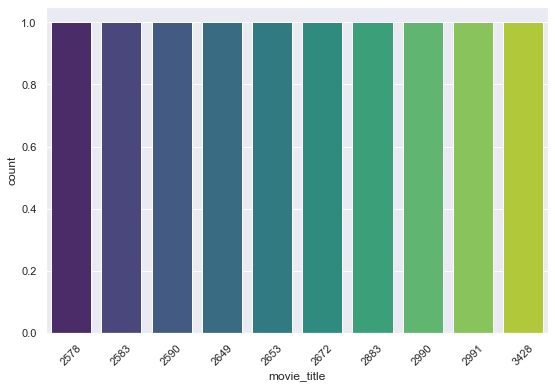

In [33]:
multipleRatings = pd.DataFrame(movieData)
multipleRatings.sort_values(by=['movie_title'], inplace=True, ascending=True)

def count_occurences():
    

multipleRatings
#multipleRatings.

# Create a visualization for the number of movies in each genre
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(9,6)})

sns.countplot(x=multipleRatings['movie_title'].value_counts()[:10], data=movieData, palette="viridis") # use the function to create the graph
plt.xticks(rotation=45) # rotate the movie genre names

#plt.show()

#multipleRatings.sort_values(by=['movie_id'], inplace=True)
#multipleRatings

##### Multiple Regression between Occupation, Age, and Highest-Rated Genre Combination Ratings
###### CITATION: Dr. Siepel's Data 1500 Course

In [29]:
# Re-create a dataframe with all fields to be used in the regression
df_reg = dumMovies[['occupation', 'age', 'rating','Animation|Comedy|Thriller', 'Sci-Fi|War', 'Animation',
                    'Film-Noir|Mystery', 'Adventure|War']].copy() # returning to dumMovies dataset for top 5 genre combos

# Drop rows that are not complete (i.e. have missing values)
df_reg.dropna(inplace=True)

# Set up target dataframe
y = df_reg[['rating']].copy()
y.reset_index(drop=True, inplace=True) 

# Set up features dataframe
X = df_reg.drop(['rating'], axis=1)
X.reset_index(drop=True, inplace=True)

### CITATION: Entire model is from Dr. Siepel's Data 1500 Course

In [30]:
dumMovies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 14 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   user_id                    1000209 non-null  int64         
 1   movie_id                   1000209 non-null  int64         
 2   rating                     1000209 non-null  int64         
 3   rating_timestamp           1000209 non-null  datetime64[ns]
 4   gender                     1000209 non-null  object        
 5   age                        1000209 non-null  int64         
 6   occupation                 1000209 non-null  int64         
 7   zip_code                   1000209 non-null  object        
 8   movie_title                1000209 non-null  object        
 9   Animation|Comedy|Thriller  1000209 non-null  uint8         
 10  Sci-Fi|War                 1000209 non-null  uint8         
 11  Animation                  1000209 no

In [31]:
# Code Block 36
# Set up scaler to put features on same basis
std_scaler = StandardScaler()

# Apply scaler to entirety of features
X_scaled = std_scaler.fit_transform(X)

In [32]:
### REFINE AND IDENTIFY IMPORTANT FEATURES
# Define recursive elimination search using cross-validated folds and scoring
rfe = RFECV(estimator=LinearRegression(), step=1, cv=KFold(n_splits=10), scoring='neg_mean_absolute_error')

# Fit defined RFE model to scaled data
rfe_model = rfe.fit(X_scaled,y)

In [33]:
# Show binary results for inclusion of each feature in the data
rfe_model.support_

array([False,  True,  True,  True,  True,  True,  True])

In [34]:
# Get list of best features by apply binary results against original feature dataframe
X.columns[rfe_model.support_]

Index(['age', 'Animation|Comedy|Thriller', 'Sci-Fi|War', 'Animation',
       'Film-Noir|Mystery', 'Adventure|War'],
      dtype='object')

In [35]:
# Use binary results to populate new feature dataframe with chosen features
X_rfe = X[X.columns[rfe_model.support_]]
X_rfe

,age,Animation|Comedy|Thriller,Sci-Fi|War,Animation,Film-Noir|Mystery,Adventure|War
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
1000204,25,0,0,0,0,0
1000205,25,0,0,0,0,0
1000206,25,0,0,0,0,0
1000207,25,0,0,0,0,0


In [36]:
### UTILIZE IDENTIFIED FEATURES TO BUILD AND EVALUATE FINAL REGRESSION MODEL
# Fit regression model on RFE chosen set of features
reg = sm.OLS(y, sm.add_constant(X_rfe)).fit()

# Create predictions and store in a list
pred = reg.predict(sm.add_constant(X_rfe)) 

# Create residuals in a list
resid = reg.resid

# Show summary statistics for regression
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1038.
Date:                Sun, 24 Oct 2021   Prob (F-statistic):               0.00
Time:                        16:19:23   Log-Likelihood:            -1.5269e+06
No. Observations:             1000209   AIC:                         3.054e+06
Df Residuals:                 1000202   BIC:                         3.054e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.4192      0.003   1128.303      0.000       3.413       3.425
age                           0.0053   9.48e-05     55.957      0.000       0.005       0.005
Animation|Comedy|Thriller     0.9094      0.042     21.412      0.000       0.826       0.993
Sci-Fi|War                    0.8605      0.030     28.548      0.000       0.801       0.920
Animation                     0.8271      0.052     15.908      0.000       0.725       0.929
Film-Noir|Mystery             0.7607      0.028     27.159      0.000       0.706       0.816
Adventure|War                 0.7400      0.027     26.917      0.000       0.686       0.794
==============================================================================
Omnibus:                    51143.264   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54483.206
Skew:                          -0.544   Prob(JB):                         0.00
Kurtosis:                       2.646   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<Figure size 1152x576 with 0 Axes>

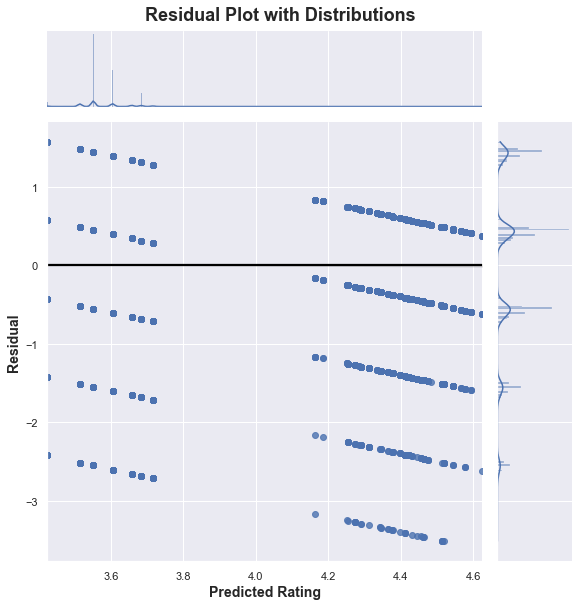

In [37]:
# Evalute residuals for RFE regression model
plt.figure(figsize=(16,8))
sns.jointplot(x=pred, y=resid, kind="reg", ratio=5, height=8, 
              line_kws={'color': 'black'})
plt.xlabel('Predicted Rating', fontweight='bold', fontsize='14', ha='center')
plt.ylabel('Residual', fontweight='bold', fontsize='14', ha='center')
plt.suptitle('Residual Plot with Distributions       ',  fontweight='bold', 
          fontsize='18', ha='center', y=1.02)
plt.show()

In [38]:
################# NOT WORKING?
# Evaluate Variance Inflation Factor for X features in RFE set
# Note: That VIF Scores are not concerning as we are not focused on individual
# relationships in the regression model, just the prediction ... which is relatively
# unaffected by multicollinearity
vif = pd.DataFrame()
vif["Feature"] = X_rfe.columns
vif["VIF Score"] = [variance_inflation_factor(X_rfe.values, i) for i in range(X_rfe.shape[1])]

# Show features with VIF above 5
index_names = vif[vif['VIF Score'] < 5 ].index
vif.drop(index_names, inplace=True)
round(vif, 1).sort_values(by='VIF Score', ascending=False)

,Feature,VIF Score


In [39]:
### USE THE FINAL MODEL TO MAKE PREDICTIONS
# Create empty copy of feature dataframe used in RFE model
df_predNew = X_rfe.head(0).copy()

# Show column names to help input new observation for prediction
df_predNew.columns

Index(['age', 'Animation|Comedy|Thriller', 'Sci-Fi|War', 'Animation',
       'Film-Noir|Mystery', 'Adventure|War'],
      dtype='object')

In [40]:
# Create observation for the following prediction:
# A Sci-Fi|War movie rated by someone age 16 with an unspecified occupation
# This particular property is an apartment in Charlestown (near the Freedom Trail) with 3 bedrooms 
# and 2 bathrooms that is set to accommodate 6, which is the number of guests that are included. 
# The property host has 2 additional listings but is not a superhost. They require a security deposit
# of $250 and a cleaning fee of $100. There is a 3-night minimum on the property rental, which is for
# the entire apartment. Instant book is not available and the property has a strict cancellation policy.
# The property owner believes they will get 1.2 reviews per month and state that they respond to emails
# within a day (code is 2).

# Set up values in feature matrix to represent new property
df_predNew.loc[0] = [0, 0, 1, 0, 0, 0]

# Add a constant value as the first field in the dataframe
df_predNew = sm.add_constant(df_predNew, prepend=True, has_constant='add')

# Check values to see if they align properly
df_predNew

,const,age,Animation|Comedy|Thriller,Sci-Fi|War,Animation,Film-Noir|Mystery,Adventure|War
0,1.0,0,0,1,0,0,0


In [41]:
# Create and show RFE prediction results for new observation
prediction_rfe = reg.get_prediction(df_predNew)
prediction_rfe.summary_frame(alpha=.05)

### CITATION: Again, credit for this model goes to Dr. Siepel and Data 1500

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,4.279717,0.030274,4.220381,4.339052,2.096209,6.463225


##### Ratings of the 5 Best-Rated Genres by Top Occupations (College/Grad Student, Other/Unverified, Executive/Managerial, Academic/Educator, Technician/Engineer)

<AxesSubplot:title={'center':'Determine whether a correlation exists between overall occupations and ratings'}>

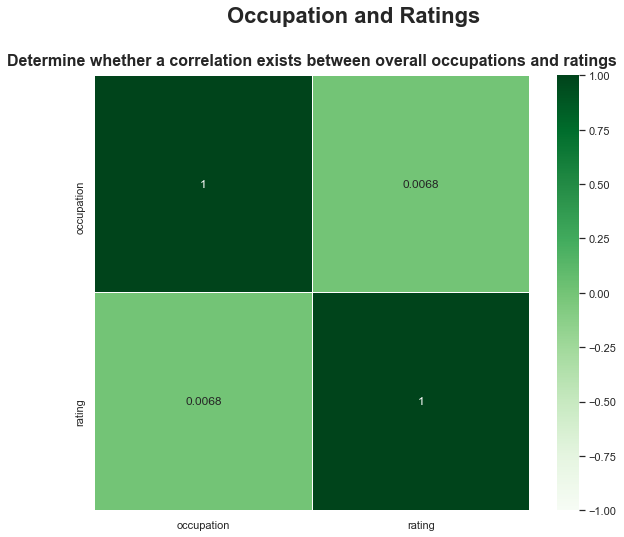

In [42]:
# Creating a heat map to determine whether an overall correlation exists between occupation and ratings
# Feature Selection
OccGen_Features = movieData[['occupation', 'rating']]

# Create a Correlation Matrix with a colored heat-map
correlation = OccGen_Features.corr()
f, ax = plt.subplots(figsize = (10,8))
plt.suptitle('Occupation and Ratings', fontweight='bold', fontsize='22', ha='center', y = 1)

plt.title('Determine whether a correlation exists between overall occupations and ratings', fontweight='bold', 
          fontsize='14', ha='center', y=1.01, size = 16)

sns.heatmap(correlation, square=True,linewidths=0.1, vmax=1.0, vmin=-1.0, cmap = "Greens", linecolor='white',annot= True)

### Citation: From class notes (5) and Dr. Siepel's notes from Introduction to Data Science

There does not seem to be an overall correlation.